In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
from dataloader import SignalDataloader
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import lightning.pytorch as pl
import yaml
from tqdm import tqdm
from ml4gw.transforms import SpectralDensity, Whiten

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

In [2]:
#data_dir = "/n/holystore01/LABS/iaifi_lab/Lab/sambt/LIGO/O4_MDC_background"
data_dir = "/n/netscratch/iaifi_lab/Lab/emoreno/O4_MDC_background/"
sample_rate = 4096
kernel_length = 0.5
psd_length = 64
fduration = 1
fftlength = 2
batch_size = 512
batches_per_epoch = 50
num_workers = 2
data_saving_file = None
duration = fduration + kernel_length

from gwak.data.prior import SineGaussianBBC, LAL_BBHPrior, GaussianBBC, CuspBBC, KinkBBC, KinkkinkBBC, WhiteNoiseBurstBBC
from ml4gw.waveforms import SineGaussian, IMRPhenomPv2, Gaussian, GenerateString, WhiteNoiseBurst

signal_classes = [
    "SineGaussian",
    "BBH",
    "Gaussian",
    "Cusp",
    "Kink",
    "KinkKink",
    "WhiteNoiseBurst",
    "Background"
]
priors = [
    SineGaussianBBC(),
    LAL_BBHPrior(),
    GaussianBBC(),
    CuspBBC(),
    KinkBBC(),
    KinkkinkBBC(),
    WhiteNoiseBurstBBC(),
    None
]
waveforms = [
    SineGaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    IMRPhenomPv2(),
    Gaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    WhiteNoiseBurst(
        sample_rate=sample_rate,
        duration=duration
    ),
    None
]
extra_kwargs = [
    None,
    {"ringdown_duration":0.9},
    None,
    None,
    None,
    None,
    None,
    None
]

In [3]:
loader = SignalDataloader(signal_classes,
    priors,
    waveforms,
    extra_kwargs,
    data_dir=data_dir,
    sample_rate=sample_rate,
    kernel_length=kernel_length,
    psd_length=psd_length,
    fduration=fduration,
    fftlength=fftlength,
    batch_size=batch_size,
    batches_per_epoch=batches_per_epoch,
    num_workers=num_workers,
    data_saving_file=data_saving_file
)
test_loader = loader.test_dataloader()

You passed a directory with a test/ directory but no val/, setting val set = test set


/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/gwak/lib/python3.11/site-packages/ml4gw/dataloading/hdf5_dataset.py:83: ContiguousHdf5Warning: File /n/netscratch/iaifi_lab/Lab/emoreno/O4_MDC_background/test/background-1402080987-3080.h5 contains datasets that were generated without using chunked storage. This can have severe performance impacts at data loading time. If you need faster loading, try re-generating your datset with chunked storage turned on.
  warnings.warn(
/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/gwak/lib/python3.11/site-packages/ml4gw/dataloading/hdf5_dataset.py:83: ContiguousHdf5Warning: File /n/netscratch/iaifi_lab/Lab/emoreno/O4_MDC_background/test/background-1402086581-267.h5 contains datasets that were generated without using chunked storage. This can have severe performance impacts at data loading time. If you need faster loading, try re-generating your datset with chunked storage turned on.
  warnings.warn(
/n/holystore01/LABS/iaifi_lab/Users/sam

In [5]:
for batch in test_loader:
    [batch] = batch
    waveforms, params, ras, decs, phics = loader.generate_waveforms(batch.shape[0])
    batch = batch.to(device)
    x = loader.multiInject(waveforms, batch)
    labels = torch.cat([(i+1)*torch.ones(loader.num_per_class[i]) for i in range(loader.num_classes)])
    break

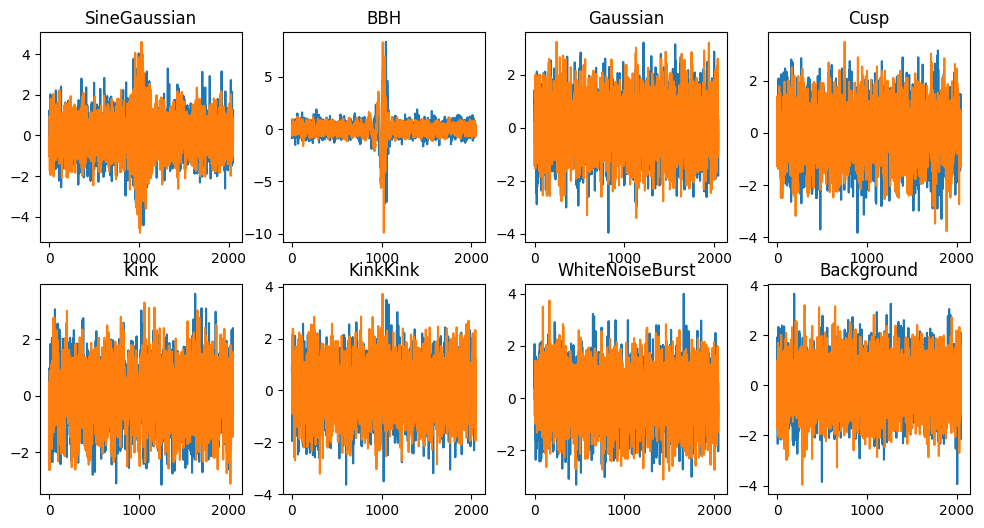

In [6]:
fig,axes = plt.subplots(2,4,figsize=(12,6))

for i, c in enumerate(signal_classes):
    plt.sca(axes[i//4,i%4])
    for k in range(1,2):
        xsel = x[labels==i+1][k,0,:]
        n = np.arange(len(xsel))
        plt.plot(n,xsel.cpu().numpy())
        xsel = x[labels==i+1][k,1,:]
        plt.plot(n,xsel.cpu().numpy())
    plt.title(c)

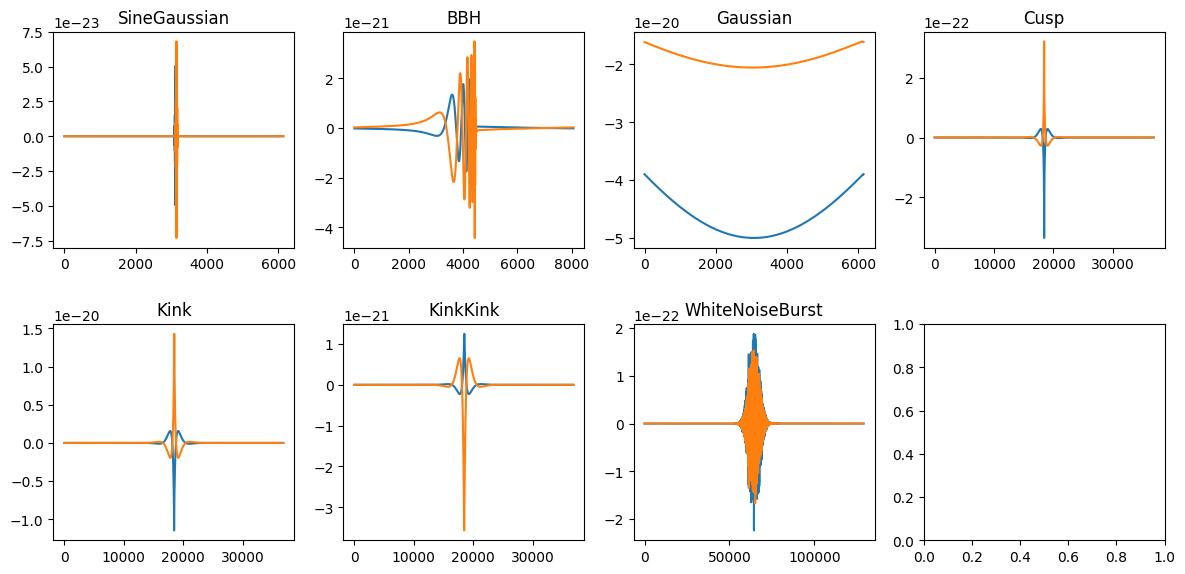

In [7]:
fig,axes = plt.subplots(2,4,figsize=(12,6))

for i, c in enumerate(signal_classes):
    plt.sca(axes[i//4,i%4])
    if waveforms[i] is None:
        continue
    xsel = waveforms[i][0,0,:]
    n = np.arange(len(xsel))
    plt.plot(n,xsel.cpu().numpy())
    xsel = waveforms[i][0,1,:]
    plt.plot(n,xsel.cpu().numpy())
    plt.title(c)
plt.tight_layout()

In [13]:
def plot(i,hp=None):

    b = batch[:1].clone()
    w = waveforms[i][:1].clone()

    split_size = int((kernel_length + fduration) * sample_rate)
    splits = [b.size(-1) - split_size, split_size]
    psd_data, bt = torch.split(b.clone(), splits, dim=-1)

    spectral_density = SpectralDensity(
        sample_rate,
        fftlength,
        average = 'median'
    )
    spectral_density = spectral_density.to('cuda') if torch.cuda.is_available() else spectral_density

    psds = spectral_density(psd_data.double())

    inj_len = w.shape[-1]
    window_len = splits[1]
    half = int((window_len - inj_len)/2)

    first_half, second_half = half, window_len - half - inj_len
    wf = F.pad(
        input=w,
        pad=(first_half, second_half),
        mode='constant',
        value=0
    )

    summed = bt + wf

    whitener = Whiten(
                fduration,
                sample_rate,
                highpass = hp,
            )
    whitener = whitener.to('cuda') if torch.cuda.is_available() else whitener

    whitened = whitener(summed.double(), psds.double())

    # normalize the input data
    stds = torch.std(whitened, dim=-1, keepdim=True)
    whitened = whitened / stds


    fig,axes = plt.subplots(1,4,figsize=(20,4))
    n = np.arange(wf.shape[-1])

    plt.sca(axes[0])
    plt.plot(n,wf[0,0,:].cpu().numpy())
    plt.plot(n,wf[0,1,:].cpu().numpy())
    plt.title('waveform')

    plt.sca(axes[1])
    plt.plot(n,bt[0,0,:].cpu().numpy())
    plt.plot(n,bt[0,1,:].cpu().numpy())
    plt.title('bkg')


    plt.sca(axes[2])
    plt.plot(n,summed[0,0,:].cpu().numpy())
    plt.plot(n,summed[0,1,:].cpu().numpy())
    plt.title('sum')

    plt.sca(axes[3])
    n2 = np.arange(whitened.size(-1))
    plt.plot(n2,whitened[0,0,:].cpu().numpy())
    plt.plot(n2,whitened[0,1,:].cpu().numpy())
    plt.title('whitened')

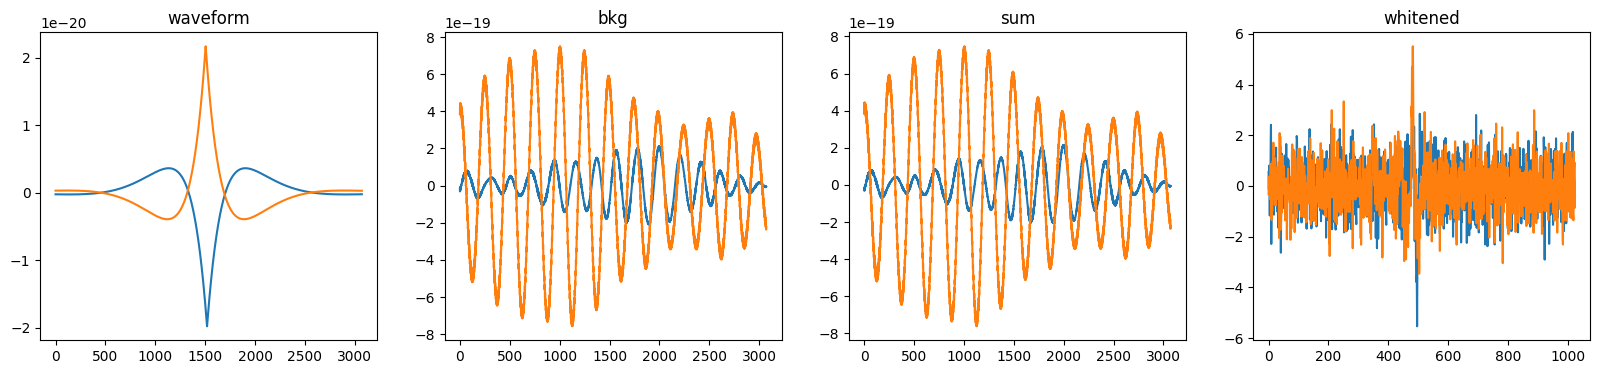

In [28]:
plot(5,hp=30)

In [4]:
from cl_models import Crayon
import yaml

#ckpt = "../output/test_S4_fixedSignals_0p5sec_v2/lightning_logs/2wla29uz/checkpoints/33-1700.ckpt"
cfg_path = "../../output/S4_SimCLR_multiSignalAndBkg/config.yaml"
with open(cfg_path,"r") as fin:
    cfg = yaml.load(fin,yaml.FullLoader)

#model = Crayon.load_from_checkpoint(ckpt,**cfg['model']['init_args'])
model = Crayon(**cfg['model']['init_args'])
model = model.eval()
model = model.to(device)

In [5]:
tot = 0
output = []
labs = []
bads = []
bad_wfs = []
bad_labels = []
bad_batches = []
train_loader = loader.train_dataloader()
for batch in tqdm(train_loader):
    [batch] = batch
    waveforms, params, ras, decs, phics = loader.generate_waveforms(batch.shape[0])
    batch = batch.to(device)
    x = loader.multiInject(waveforms, batch)
    labels = torch.cat([(i+1)*torch.ones(loader.num_per_class[i]) for i in range(loader.num_classes)])
    
    with torch.no_grad():
        y = model.model(x).cpu().numpy()
    if np.any(np.isnan(y)):
        mask = torch.tensor(np.any(np.isnan(y),axis=1)).to(device)
        bads.append(x[mask].cpu().numpy())
        bad_batches.append(batch[mask].cpu().numpy())
        bad_labels.append(labels[mask.cpu()].cpu().numpy())
        for idx in np.arange(x.shape[0])[mask.cpu().numpy()]:
            iw = 0
            icurr = 0
            while idx not in range(icurr,icurr+loader.num_per_class[iw]):
                icurr += waveforms[iw].shape[0]
                iw += 1
            if iw < len(loader.num_per_class)-1:
                bad_wfs.append(waveforms[iw][idx-icurr].cpu().numpy())
            else:
                bad_wfs.append(batch[idx].cpu().numpy())
    
    output.append(y)
    labs.append(labels.cpu().numpy())
    
    tot += y.shape[0]

l = np.concatenate(labs)
y = np.concatenate(output,axis=0)
bads = np.concatenate(bads,axis=0)
bad_labels = np.concatenate(bad_labels,axis=0)
bad_batches = np.concatenate(bad_batches,axis=0)

/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/gwak/lib/python3.11/site-packages/ml4gw/dataloading/hdf5_dataset.py:83: ContiguousHdf5Warning: File /n/netscratch/iaifi_lab/Lab/emoreno/O4_MDC_background/train/background-1401696321-8160.h5 contains datasets that were generated without using chunked storage. This can have severe performance impacts at data loading time. If you need faster loading, try re-generating your datset with chunked storage turned on.
  warnings.warn(
/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/gwak/lib/python3.11/site-packages/ml4gw/dataloading/hdf5_dataset.py:83: ContiguousHdf5Warning: File /n/netscratch/iaifi_lab/Lab/emoreno/O4_MDC_background/train/background-1402046551-23281.h5 contains datasets that were generated without using chunked storage. This can have severe performance impacts at data loading time. If you need faster loading, try re-generating your datset with chunked storage turned on.
  warnings.warn(
/n/holystore01/LABS/iaifi_lab/Users

In [6]:
bad_batches

array([[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 5.7628871e-18,  5.7406194e-18,  5.7199717e-18, ...,
          2.3409844e-18,  2.2866337e-18,  2.2319637e-18]],

       [[-5.0281129e-18, -5.0430629e-18, -5.0589361e-18, ...,
         -3.0176076e-18, -3.0420510e-18, -3.0671313e-18],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[-4.9186736e-18, -4.9797956e-18, -5.0390809e-18, ...,
          1.9631283e-18,  1.9084717e-18,  1.8531257e-18],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[ 2.2358644e-18,  2.3216482e-18,  2.2825433e-18, ...,
         -5.0305346e-19, -4.9376753e-19, -4.7670543e-19],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[ 0.0000000e+00,  0.0000

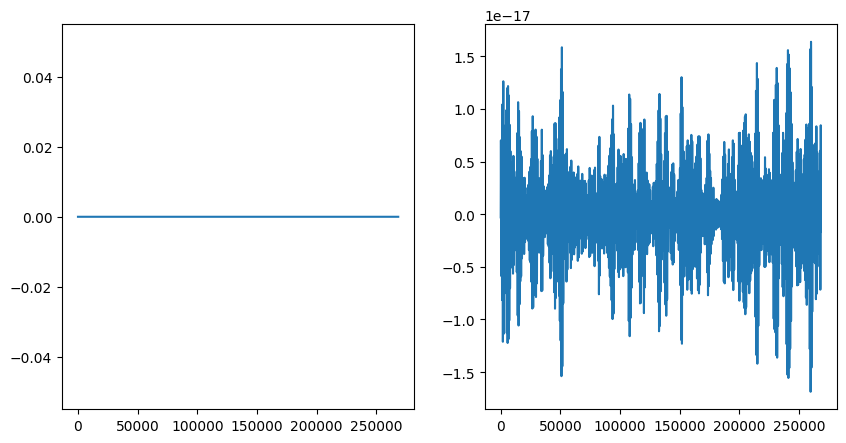

In [16]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
i=4
x = np.arange(bad_batches.shape[2])
plt.sca(axes[0])
l=plt.plot(x,bad_batches[i][0,:])
plt.sca(axes[1])
l=plt.plot(x,bad_batches[i][1,:])

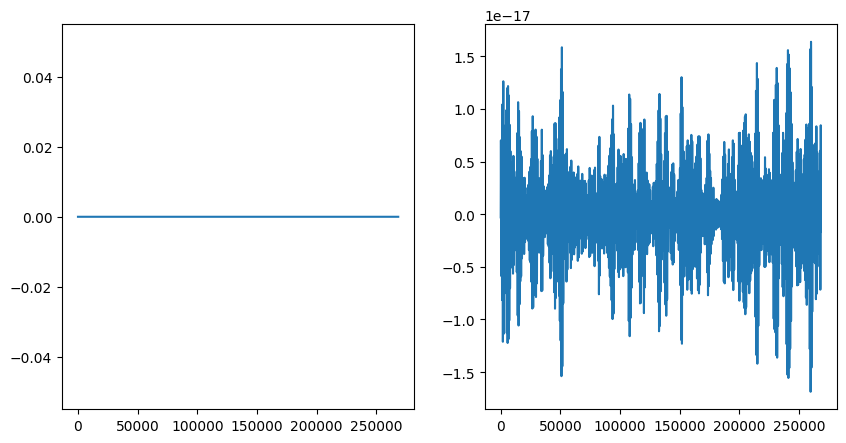

In [26]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
i=4
x = np.arange(bad_wfs[i].shape[1])
plt.sca(axes[0])
l=plt.plot(x,bad_wfs[i][0,:])
plt.sca(axes[1])
l=plt.plot(x,bad_wfs[i][1,:])

In [3]:
import h5py
import os
from tqdm import tqdm
path = "/n/netscratch/iaifi_lab/Lab/emoreno/O4_MDC_background/train/"
outpath = "/n/holystore01/LABS/iaifi_lab/Lab/sambt/LIGO/O4_MDC_background/train/"
files = os.listdir(path)
for f in tqdm(files):
    with h5py.File(f"{path}/{f}","r") as fin:
        if len(fin["H1"]) < 4096*(64 + 1 + 1):
            print(f)
#            continue
#        h1 = fin["H1"][()]
#        l1 = fin["L1"][()]
#    with h5py.File(f"{outpath}/{f}","w") as fout:
#        fout.create_dataset("H1",data=h1,chunks=True)
#        fout.create_dataset("L1",data=l1,chunks=True)

 59%|█████▊    | 41/70 [00:00<00:00, 46.11it/s]

background-1403068780-64.h5
background-1403218496-10.h5


100%|██████████| 70/70 [00:01<00:00, 43.90it/s]

background-1403908550-14.h5


In [31]:
np.any(h1==0)

False

In [ ]:
tot = 0
output = []
labs = []
for batch in tqdm(test_loader):
    [batch] = batch
    waveforms, params, ras, decs, phics = loader.generate_waveforms(batch.shape[0])
    batch = batch.to(device)
    x = loader.multiInject(waveforms, batch)
    labels = torch.cat([(i+1)*torch.ones(loader.num_per_class[i]) for i in range(loader.num_classes)])
    
    with torch.no_grad():
        y = model.model(x).cpu().numpy()
    
    output.append(y)
    labs.append(labels.cpu().numpy())
    
    tot += y.shape[0]

l = np.concatenate(labs)
y = np.concatenate(output,axis=0)

In [54]:
with torch.no_grad():
    y1 = model.model(x).cpu().numpy()
    y2 = model.model(x).cpu().numpy()

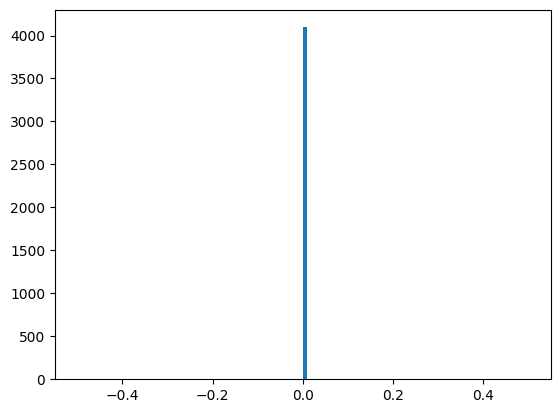

In [55]:
h=plt.hist((y1-y2).flatten(),bins=100)

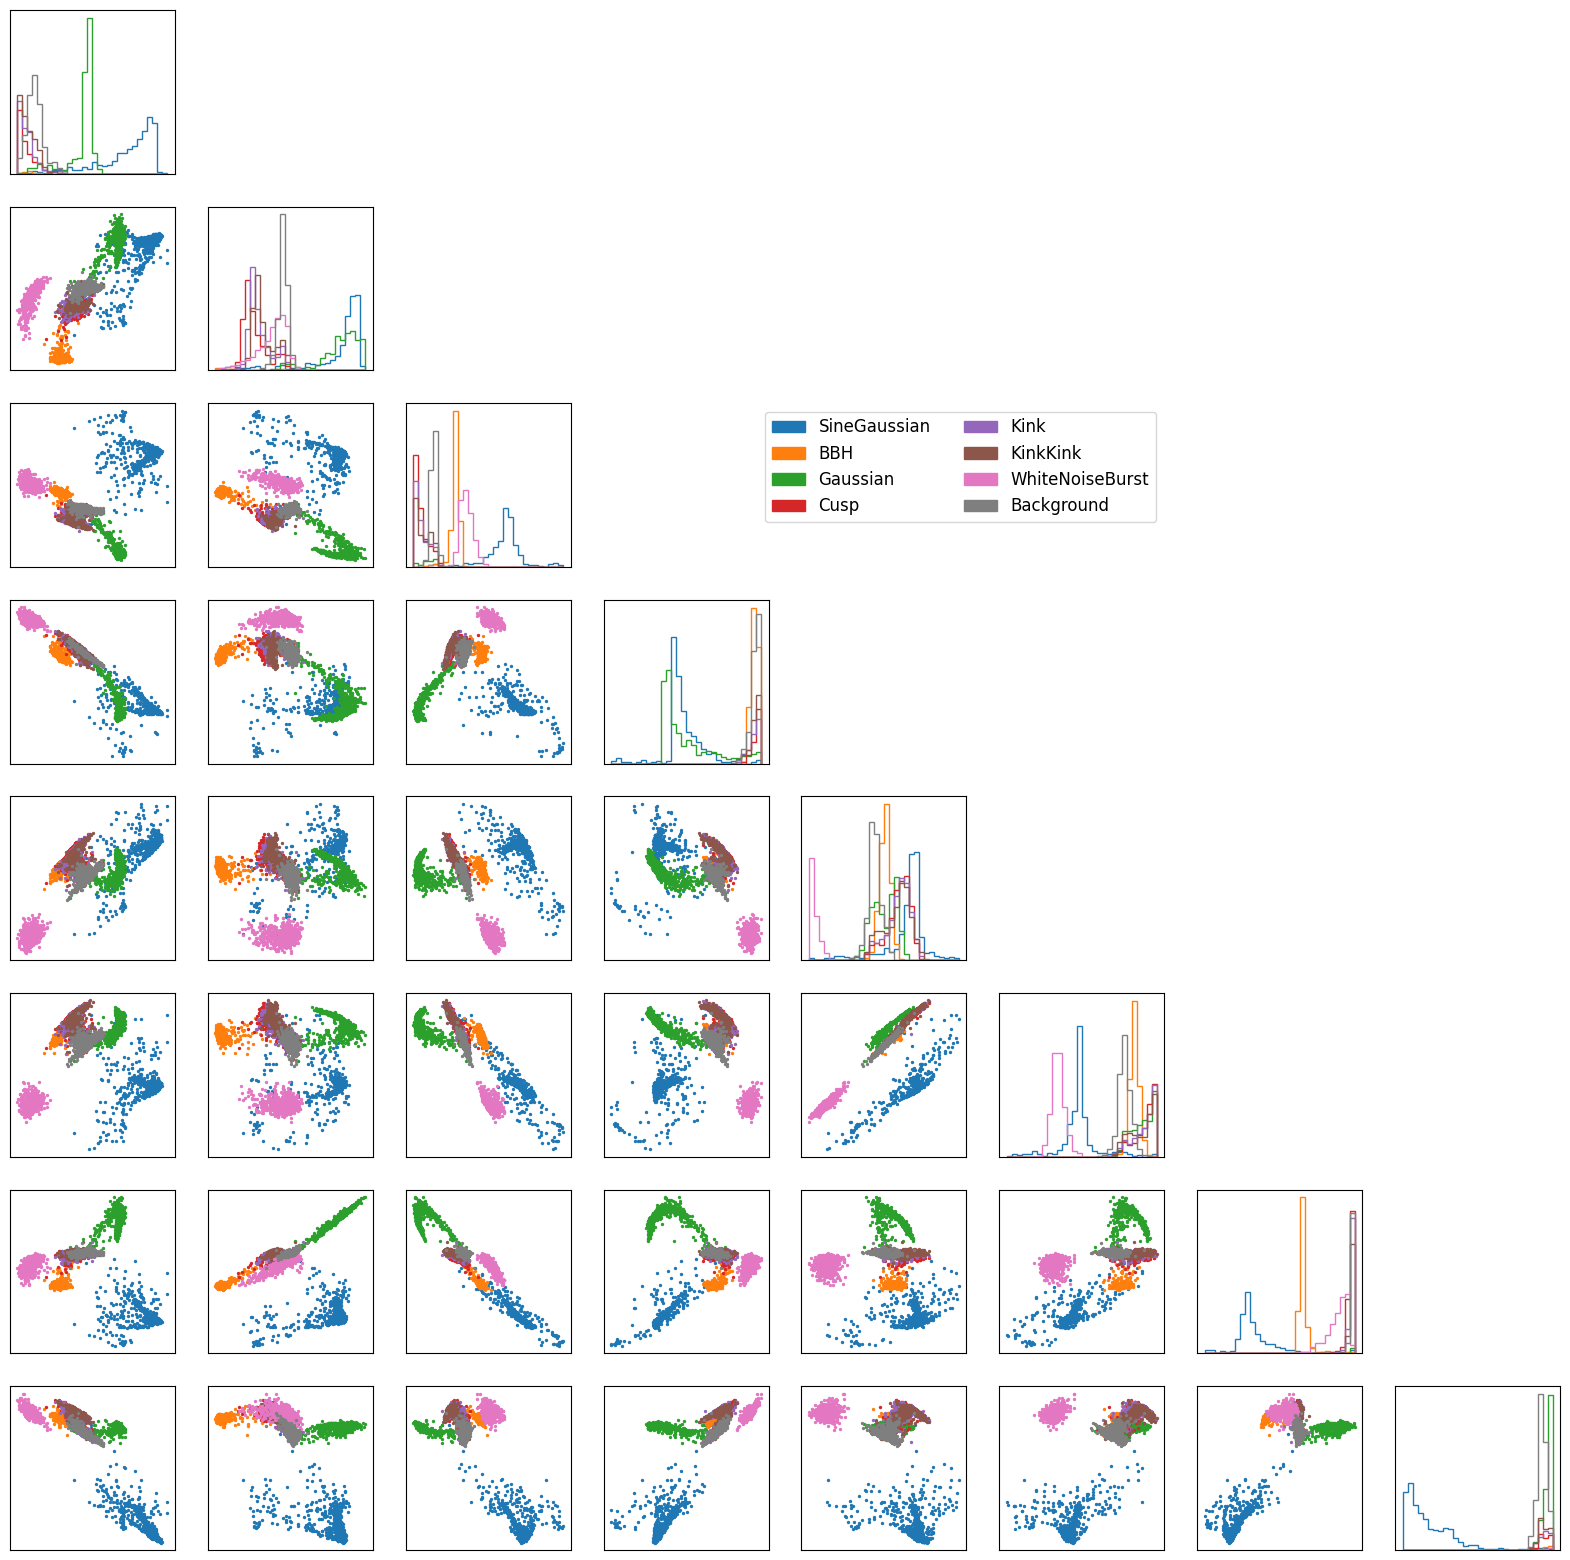

In [70]:
#import corner

N = y.shape[1]
labs_uniq = sorted(list(set(l)))
fig,axes = plt.subplots(N,N,figsize=(20,20))

for i in range(y.shape[1]):
    for j in range(i+1,y.shape[1]):
        plt.sca(axes[i,j])
        plt.axis('off')

for i in range(y.shape[1]):
    plt.sca(axes[i,i])
    plt.xticks([])
    plt.yticks([])
    bins = 30
    for j,lab in enumerate(labs_uniq):
        h,bins,_ = plt.hist(y[l==lab][:,i],bins=bins,histtype='step',color=f"C{j}")
        
for i in range(1,y.shape[1]):
    for j in range(i):
        plt.sca(axes[i,j])
        plt.xticks([])
        plt.yticks([])
        for k,lab in enumerate(labs_uniq):
            ysel = y[l==lab]
            plt.scatter(ysel[:,j],ysel[:,i],s=2,color=f"C{k}")
            
from matplotlib.patches import Patch
plt.sca(axes[2,5])
patches = []
for k,lab in enumerate(labs_uniq):
    patches.append(Patch(color=f"C{k}",label=signal_classes[k]))
plt.legend(handles=patches,ncol=2,fontsize=12)

#plt.tight_layout()

plt.savefig("test.png")
#for i,lab in enumerate(sorted(list(set(l)))):
#    corner.corner(y[l==lab],fig=fig,color=f"C{i}")

In [73]:
y.min()

-4.927156